In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np 

import matplotlib.pyplot as plt

## Simple N-body code using Python

- Following the [article and code by Philip Mocz](https://medium.com/swlh/create-your-own-n-body-simulation-with-python-f417234885e9)
- Code is available on [Github](https://github.com/pmocz/nbody-python/blob/master/nbody.py)


In [2]:
# Setup the simulation
N = 100   # Number of particles

# Randomize the initial conditions
np.random.seed(17)

# Particle mass: equal mass particle
mass = 20.0 * np.ones((N, 1)) / N   # So the total mass of the particle is 20

# Random positions and velocities
pos = np.random.randn(N, 3)
vel = np.random.randn(N, 3)

# Convert to Center-of-Mass frame
vel -= np.mean(mass * vel, axis=0) / np.mean(mass)

#The softening parameter in the code is a small number added to avoid numerical issues when 2 particles are close to each other, 
# in which case the acceleration from the ‘inverse square-law’ goes to infinity.
softening = 0.1

# Using natural's unit: gravitational constant G = 1
G = 1.0

### Force Calculation

- Assume a system of $N$ point articles. Each has a mass, a 3-D position and velocity value.
- Calclulate the acceleration of each particles by:
$$
\mathbf{a}_{i}=G \sum_{j \neq i} m_{j} \frac{\mathbf{r}_{j}-\mathbf{r}_{i}}{\left|\mathbf{r}_{j}-\mathbf{r}_{i}\right|^{3}}
$$

In [3]:
# Notice the difference here
x = pos[:, 0:1]
print(x.shape)
print((x.T - x).shape)

(100, 1)
(100, 100)


In [4]:
x = pos[:, 0]
print(x.shape)
print((x.T - x).shape)

(100,)
(100,)


In [5]:
def get_acceleration(mass, pos, softening=0.1):
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx ** 2 + dy ** 2 + dz ** 2 + softening ** 2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** -1.5

    # Accelerations in three directions
    # @ is for matrix mulitiplication
    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # The accerlation for each partilce in 3 directions 
    # Shape (N, 3)
    a = np.hstack((ax, ay, az))
    
    return a

In [6]:
acc = get_acceleration(mass, pos)

## Time Integration

- The positions and velocities are updated using a leap-frog scheme (‘kick-drift-kick’). For each timestep Δt, each particle receives a half-step ‘kick’:
$$
\mathbf{v}_{i}=\mathbf{v}_{i}+\frac{\Delta t}{2} \times \mathbf{a}_{i}
$$

- followed by a full-step ‘drift’:
$$
\mathbf{r}_{i}=\mathbf{r}_{i}+\Delta t \times \mathbf{v}_{i}
$$

- followed by another half-step ‘kick’.
- The ‘kick-drift-kick’ is a highly accurate second-order technique that does a good job at preserving the total energy of the system.

In [7]:
# Time step
dt = 0.01

# The 1/2 kick
vel += acc * dt / 2.0

# Full step drift 
pos += vel * dt

# Update acceleration
acc = get_acceleration(mass, pos, softening=softening)

# Another 1/2 kick
vel += acc * dt / 2.0

## Energy Diagnostics

- Total energy of the system

$$
E_{\mathrm{Tot}}=\sum_{i} \frac{1}{2} m_{i} v_{i}^{2}-\sum_{1 \leq i<j \leq N} \frac{G m_{i} m_{j}}{\left|r_{j}-r_{i}\right|}
$$


In [8]:
np.sum(np.sum( mass * vel**2 ))

58.87669978455333

In [9]:
(mass * vel ** 2).sum()

58.87669978455333

In [10]:
def get_energy(mass, pos, vel):
    # kinetic energy
    KE = 0.5 * (mass * vel ** 2).sum()
    
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    
    # matrix that stores 1/r for all particle pairwise particle separations 
    inv_r = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    inv_r[inv_r > 0] = 1.0 / inv_r[inv_r > 0]
    
    # sum over upper triangle, to count each interaction only once
    # numpy.triu: Return a copy of a matrix with the elements below the k-th diagonal zeroed.
    PE = G * np.sum(np.sum(np.triu(-(mass * mass.T) * inv_r, k=1)))
    
    return KE, PE

In [11]:
get_energy(mass, pos, vel)

(29.438349892276666, -106.37854632888487)

## Put things together

In [40]:
# Setup the simulation
N = 100   # Number of particles

# Randomize the initial conditions
np.random.seed(17)

# Particle mass: equal mass particle
#mass = 20.0 * np.ones((N, 1)) / N   # So the total mass of the particle is 20

mass = np.random.random((N, 1))
mass = 20.0 * mass / mass.sum()

# Random positions and velocities
pos = np.random.randn(N, 3)
vel = np.random.randn(N, 3)

# Convert to Center-of-Mass frame
vel -= np.mean(mass * vel, axis=0) / np.mean(mass)

#The softening parameter in the code is a small number added to avoid numerical issues when 2 particles are close to each other, 
# in which case the acceleration from the ‘inverse square-law’ goes to infinity.
softening = 0.05

# Using natural's unit: gravitational constant G = 1
G = 1.0

# Time stup
t = 0       # Current time
dt = 0.01   # Timestep
tEnd = 10.0 # End time of the simulation
Nt = int(np.ceil((tEnd - t) / dt))  # Number of timesteps

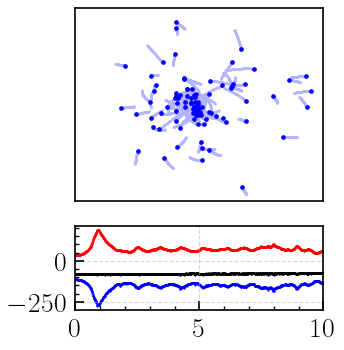

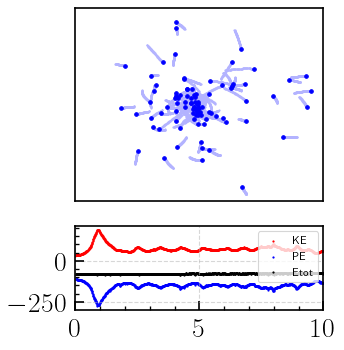

In [41]:
acc = get_acceleration(mass, pos, softening=softening)

ke, pe = get_energy(mass, pos, vel)

# Keep the result
pos_save = np.zeros((N, 3, Nt + 1))
ke_save = np.zeros(Nt + 1)
pe_save = np.zeros(Nt + 1)

pos_save[:, :, 0] = pos
ke_save[0] = ke
pe_save[0] = pe
t_all = np.arange(Nt + 1) * dt

# prep figure
fig = plt.figure(figsize=(4, 5), dpi=80)
grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
ax1 = plt.subplot(grid[0: 2, 0])
ax2 = plt.subplot(grid[2, 0])

for i in range(Nt):
    # The 1/2 kick
    vel += acc * dt / 2.0

    # Full step drift 
    pos += vel * dt

    # Update acceleration
    acc = get_acceleration(mass, pos, softening=softening)

    # Another 1/2 kick
    vel += acc * dt / 2.0
    
    # Update time 
    t += dt
    
    # Update energy 
    ke, pe = get_energy(mass, pos, vel)
    
    pos_save[:, :, i + 1] = pos
    ke_save[i + 1] = ke
    pe_save[i + 1] = pe
    
    if i == Nt - 1:
        plt.sca(ax1)
        plt.cla()
        xx = pos_save[:, 0, max(i - 50, 0): i + 1]
        yy = pos_save[:, 1, max(i - 50, 0): i + 1]
        plt.scatter(xx, yy, s=1, color=[.7,.7,1])
        plt.scatter(pos[:, 0], pos[:, 1], s=10, color='blue')
        ax1.set(xlim=(-5, 5), ylim=(-5, 5))
        #ax1.set_aspect('equal', 'box')
        ax1.set_xticks([])
        ax1.set_yticks([])

        plt.sca(ax2)
        plt.cla()
        plt.scatter(t_all, ke_save, color='red', s=1, label='KE' if i == Nt - 1 else "")
        plt.scatter(t_all, pe_save, color='blue',s=1, label='PE' if i == Nt - 1 else "")
        plt.scatter(t_all, ke_save + pe_save, color='black', s=1, label='Etot' if i == Nt - 1 else "")
        ax2.set(xlim=(0, tEnd),)
        #ax2.set_aspect(0.007)
        plt.pause(0.001)
    
plt.sca(ax2)
ax2.legend(loc='upper right')